<h1>CNN for to detect brain tumors using MRI images</h1>

In [176]:
# Импорт необходимых библиотек
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                     BatchNormalization, LeakyReLU, GlobalAveragePooling2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.regularizers import l2

In [177]:
# Определяем пути к директориям и категории данных
data_dir = 'data/raw'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')


In [178]:
# Создание необходимых директорий
target_size = (224, 224)
batch_size = 32
learning_rate = 1e-4
num_epochs = 30

In [179]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [180]:
# Генераторы данных
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)



Found 176 images belonging to 2 classes.
Found 38 images belonging to 2 classes.


In [181]:
# Рассчитать веса классов
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [182]:
# Предобученная модель (MobileNet)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [183]:
# Заморозка слоев базовой модели
for layer in base_model.layers:
    layer.trainable = False

In [184]:
# Компиляция модели
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [185]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [186]:
# Обучение модели
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=num_epochs,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

C:\Users\ogkri\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 619ms/step - accuracy: 0.5687 - loss: 4.8627 - val_accuracy: 0.5789 - val_loss: 4.6626
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - accuracy: 0.5113 - loss: 4.8737 - val_accuracy: 0.6316 - val_loss: 4.5824
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - accuracy: 0.7594 - loss: 4.5448 - val_accuracy: 0.6842 - val_loss: 4.5039
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step - accuracy: 0.6543 - loss: 4.5287 - val_accuracy: 0.7105 - val_loss: 4.4157
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 487ms/step - accuracy: 0.7250 - loss: 4.3753 - val_accuracy: 0.7895 - val_loss: 4.3280
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 440ms/step - accuracy: 0.7564 - loss: 4.4098 - val_accuracy: 0.8158 - val_loss: 4.2593
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 467ms/step - accuracy: 0.7916 - loss: 4.2768 - val_accuracy: 0.8421 - val_loss: 4.1810
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - accuracy: 0.7964 - loss: 4.3036 - val_accuracy: 0.8158 - val_loss:

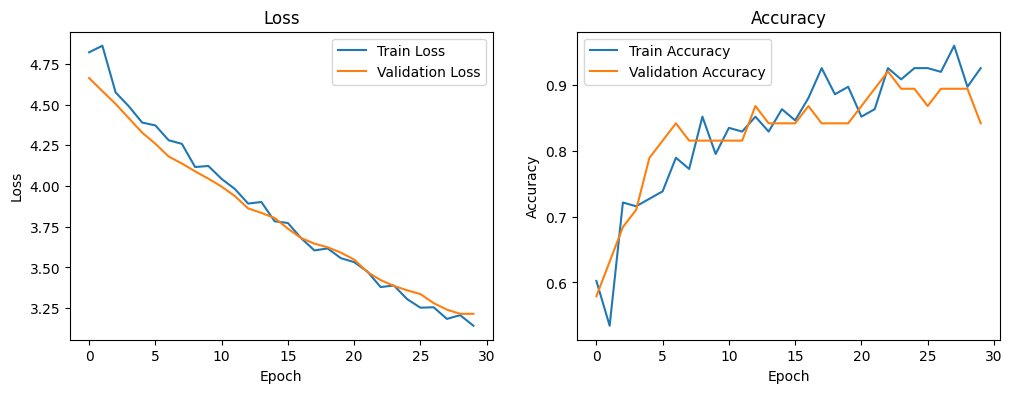

In [187]:
# Графики обучения
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()
    
plot_training_history(history)

In [188]:
# Оценка модели
print("Evaluating model on test data...")
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

results = model.evaluate(test_generator)
print(f"Test Loss: {results[0]:.4f}, Test Accuracy: {results[1]:.4f}")


Evaluating model on test data...
Found 39 images belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8178 - loss: 3.3689
Test Loss: 3.3679, Test Accuracy: 0.8205
